In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
    
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
cwd = os.getcwd()
store_TG_TN_TX_RR_HU_PP = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-tg-tn-tx-rr-hu-pp.zarr'
ds_multi = xr.open_dataset(store_TG_TN_TX_RR_HU_PP, engine='zarr', chunks={})

store_SURFACE_DOWNWELLING = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-surface-downwelling.zarr'
ds_rad = xr.open_dataset(store_SURFACE_DOWNWELLING, engine='zarr', chunks={})

In [4]:
def check_data_info():
    print("time serial:")
    print("*" * 40)
    print(f"multi_time from: {ds_multi.time.min().values} to {ds_multi.time.max().values}")
    print(f"radation_time from: {ds_rad.time.min().values} to {ds_rad.time.max().values}")
    
    print("spatial:")
    print("*" * 40)
    print(f"multi_latitude from: {ds_multi.latitude.min().values:.2f} to {ds_multi.latitude.max().values:.2f}")
    print(f"multi_longitude from: {ds_multi.longitude.min().values:.2f} to {ds_multi.longitude.max().values:.2f}")
    print(f"radiation_latitude from: {ds_rad.latitude.min().values:.2f} to {ds_rad.latitude.max().values:.2f}")
    print(f"radiation_latitude from: {ds_rad.longitude.min().values:.2f} to {ds_rad.longitude.max().values:.2f}")

check_data_info()

time serial:
****************************************
multi_time from: 1950-01-01T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
radation_time from: 1950-01-01T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
spatial:
****************************************
multi_latitude from: 25.05 to 71.45
multi_longitude from: -24.95 to 45.45
radiation_latitude from: 25.05 to 70.95
radiation_latitude from: -24.95 to 44.95


In [5]:
def normalize_data(data, mean=None, std=None):
    if mean is None:
        mean = np.nanmean(data, axis=(0, 2, 3), keepdims=True)
        std = np.nanstd(data, axis=(0, 2, 3), keepdims=True)
        std = np.where(std == 0, 1.0, std)
    
    normalized = (data - mean) / std
    
    normalized = np.nan_to_num(normalized, nan=0.0)
    
    return normalized, mean, std

In [6]:
#time from 1950 to 2020
#latitude from 25 to 69(X)
#longitude form -24 to 44(X)
#train=80%(20% in val_dataset) test=20% 


#since the datas on the ocean range are NaN, So I choose Hungary(latitude from 45 to 49 and longitude from 16 to 23) to train 



def prepare_nn_data(ds_multi, ds_rad, 
                    lat_range=(45, 49), 
                    lon_range=(16, 23),
                    train_ratio=0.8,
                    val_ratio=0.8,
                    time_sample_freq=1,
                    batch_size=32):

    ds_multi = ds_multi.sortby("time")
    ds_rad   = ds_rad.sortby("time")


    _, idx_multi = np.unique(ds_multi.time.values, return_index=True)
    ds_multi = ds_multi.isel(time=idx_multi)

    _, idx_rad = np.unique(ds_rad.time.values, return_index=True)
    ds_rad = ds_rad.isel(time=idx_rad)


    common_time = np.intersect1d(ds_multi.time.values, ds_rad.time.values)
    ds_multi = ds_multi.sel(time=common_time)
    ds_rad   = ds_rad.sel(time=common_time)


    ds_multi = ds_multi.sel(time=slice("1950-01-01", "2020-12-31"))
    ds_rad   = ds_rad.sel(time=slice("1950-01-01", "2020-12-31"))


    print(f"   spatial range: latitude {lat_range}, longitude {lon_range}")
    print(f"   time sample frequency: {time_sample_freq}")


    bbox_multi = ds_multi.where(
        (ds_multi.latitude >= lat_range[0]) & 
        (ds_multi.latitude <= lat_range[1]) &
        (ds_multi.longitude >= lon_range[0]) &
        (ds_multi.longitude <= lon_range[1]),
        drop=True
    )
    
    bbox_rad = ds_rad.where(
        (ds_rad.latitude >= lat_range[0]) & 
        (ds_rad.latitude <= lat_range[1]) &
        (ds_rad.longitude >= lon_range[0]) &
        (ds_rad.longitude <= lon_range[1]),
        drop=True
    )


    bbox_multi = bbox_multi.interpolate_na(dim="latitude", method="linear")
    bbox_multi = bbox_multi.interpolate_na(dim="longitude", method="linear")
    bbox_rad   = bbox_rad.interpolate_na(dim="latitude", method="linear")
    bbox_rad   = bbox_rad.interpolate_na(dim="longitude", method="linear")


    bbox_multi_sampleed = bbox_multi.isel(time=slice(0, None, time_sample_freq))
    bbox_rad_sampleed   = bbox_rad.isel(time=slice(0, None, time_sample_freq))
    
    n_time = len(bbox_multi_sampleed.time)
    n_train = int(n_time * train_ratio)

    print('*'*50)
    print(f"   number of time samples: {n_time}")


    train_multi = bbox_multi_sampleed.isel(time=slice(0, n_train))
    test_multi  = bbox_multi_sampleed.isel(time=slice(n_train, None))

    train_rad = bbox_rad_sampleed.isel(time=slice(0, n_train))
    test_rad  = bbox_rad_sampleed.isel(time=slice(n_train, None))

    print('*'*50)
    print(f"   train samples: {len(train_multi.time)}")
    print(f"   test samples: {len(test_multi.time)}")

    print('*'*50)
    print('predictors: rr pp hu qq')
    print('predictand: tg')


    X_train_rr = train_multi['rr'].values.astype(np.float32)
    X_train_pp = train_multi['pp'].values.astype(np.float32)
    X_train_hu = train_multi['hu'].values.astype(np.float32)
    X_train_qq = train_rad['qq'].values.astype(np.float32)
    y_train    = train_multi['tg'].values.astype(np.float32)
    
    X_test_rr = test_multi['rr'].values.astype(np.float32)
    X_test_pp = test_multi['pp'].values.astype(np.float32)
    X_test_hu = test_multi['hu'].values.astype(np.float32)
    X_test_qq = test_rad['qq'].values.astype(np.float32)
    y_test    = test_multi['tg'].values.astype(np.float32)


    y_train = np.nan_to_num(y_train, nan=0.0)
    y_test  = np.nan_to_num(y_test,  nan=0.0)


    X_train_nn = np.stack([X_train_rr, X_train_pp, X_train_hu, X_train_qq], axis=1)
    X_test_nn  = np.stack([X_test_rr,  X_test_pp,  X_test_hu,  X_test_qq ], axis=1)


    X_train_norm, train_mean, train_std = normalize_data(X_train_nn)
    X_test_norm,  _,          _         = normalize_data(X_test_nn, train_mean, train_std)


    X_train_tensor = torch.FloatTensor(X_train_norm)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor  = torch.FloatTensor(X_test_norm)
    y_test_tensor  = torch.FloatTensor(y_test)


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    train_size = int(val_ratio * len(train_dataset))
    val_size   = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  pin_memory=True)
    val_loader   = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    data_dict = {
        'train_loader': train_loader,
        'val_loader':   val_loader,
        'test_loader':  test_loader,
        'input_shape': X_train_nn.shape[1:],  
        'output_shape': y_train.shape[1:], 
        'time_train': train_multi.time.values,
        'time_test':  test_multi.time.values,
        'normalization': {
            'mean': train_mean,
            'std': train_std
        },
        'spatial_info': {
            'latitude': train_multi.latitude.values,
            'longitude': train_multi.longitude.values
        }
    }

    print('FINISH')
    return data_dict


In [7]:
data_dict = prepare_nn_data(ds_multi, ds_rad)

   spatial range: latitude (45, 49), longitude (16, 23)
   time sample frequency: 1
**************************************************
   number of time samples: 25922
**************************************************
   train samples: 20737
   test samples: 5185
**************************************************
predictors: rr pp hu qq
predictand: tg
FINISH


In [8]:
#test the data

def visualize_sample_data_separate():

    batch_X, batch_y = next(iter(data_dict['train_loader']))
    
    sample_X = batch_X[0]
    sample_y = batch_y[0]
    

    variables = ['RR (daily precipitation sum)', 'PP (daily mean sea-level pressure)', 
                 'HU (relative humidity)', 'QQ (global radiation)']
    cmaps = ['Blues', 'viridis', 'Greens', 'YlOrRd']
    units = ['mm', 'hPa', '%', 'W/m²']
    

    for i in range(4):
        plt.figure(figsize=(10, 6))
        im = plt.imshow(sample_X[i].cpu().numpy(), cmap=cmaps[i])
        plt.title(f'Input: {variables[i]}')
        plt.colorbar(im, label=units[i])
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()
    

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sample_y.cpu().numpy(), cmap='RdBu_r')
    plt.title('Output: TG (daily mean temperature)')
    plt.colorbar(im, label='°C')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()
    

    print("data range: ")

    for i, var in enumerate(variables):
        print('*' * 50)
        print(f"{var}: [{sample_X[i].min():.2f}, {sample_X[i].max():.2f}]")

    print('*' * 50)
    print(f"TG (temperature): [{sample_y.min():.2f}, {sample_y.max():.2f}]")

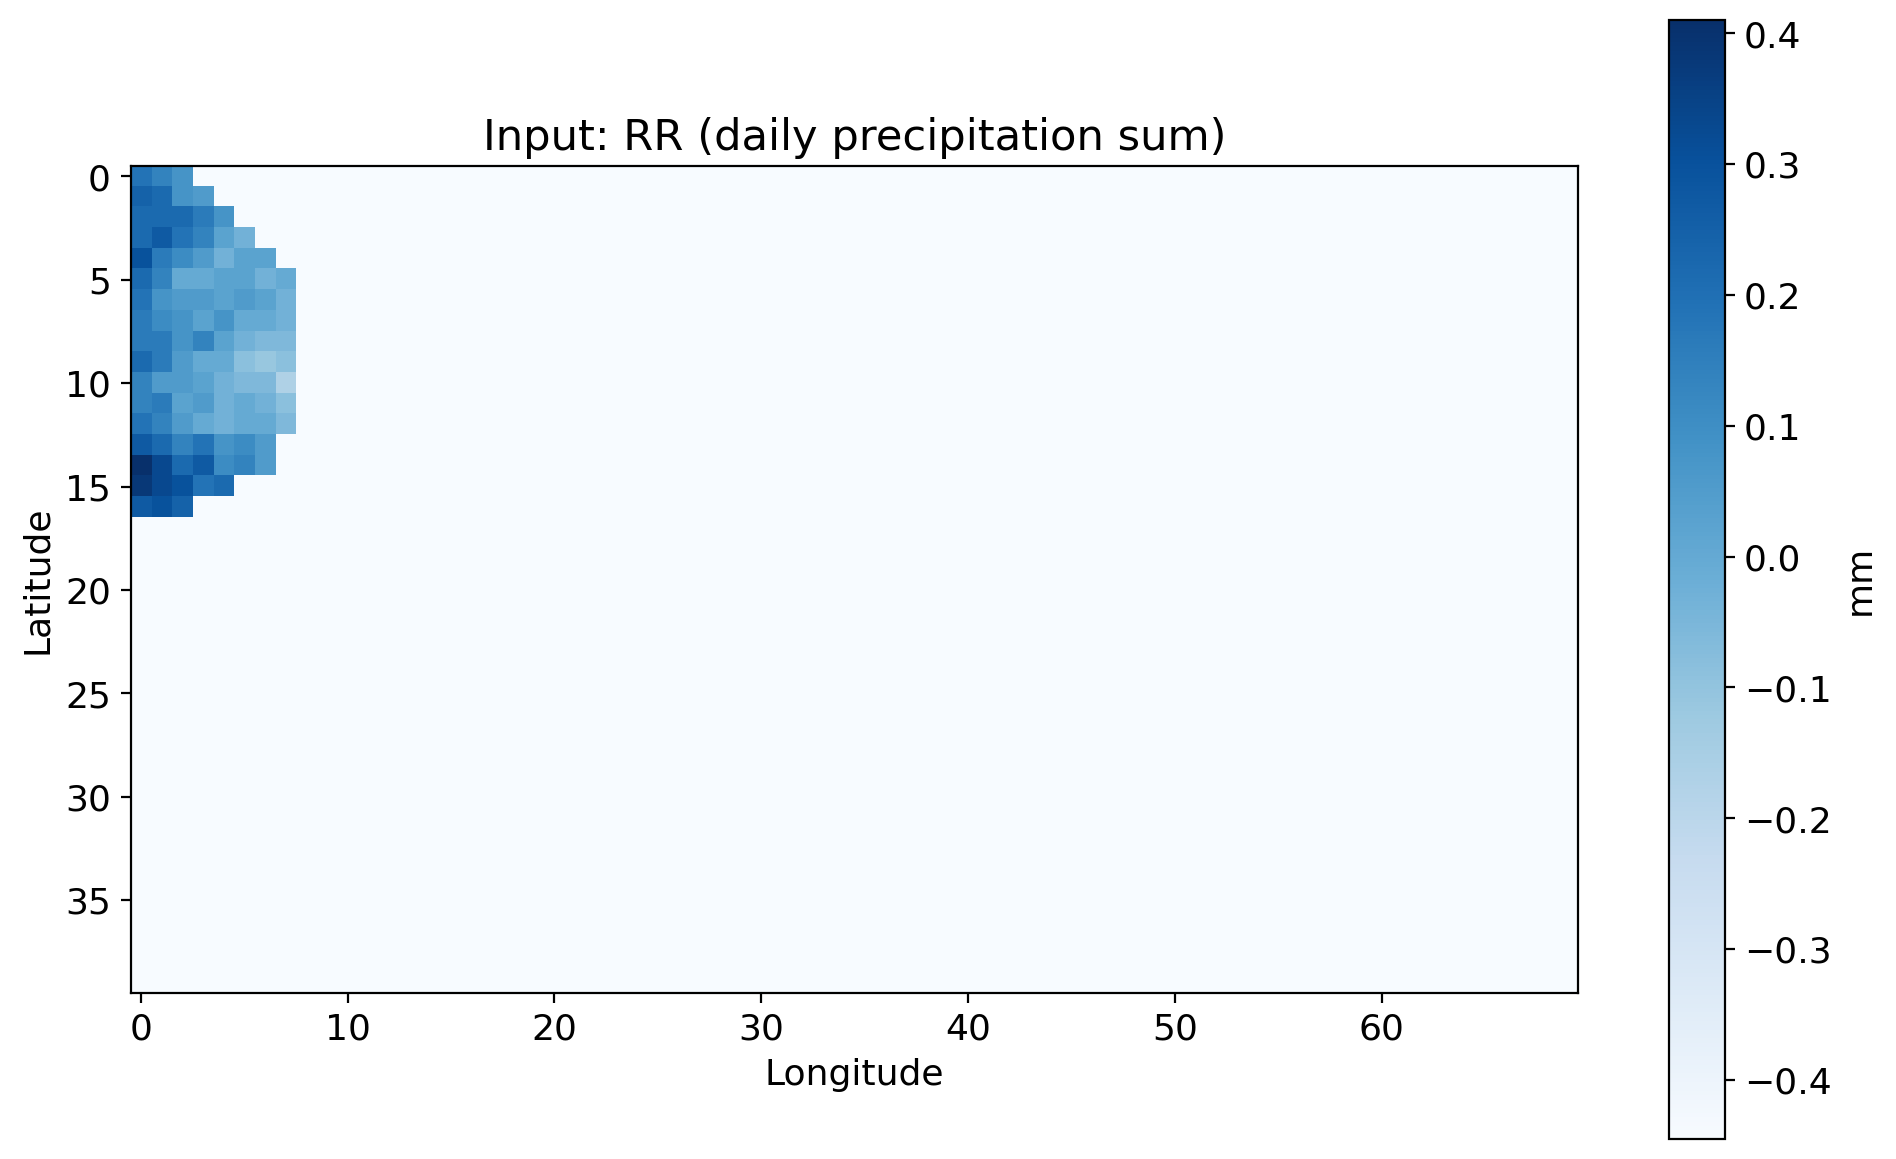

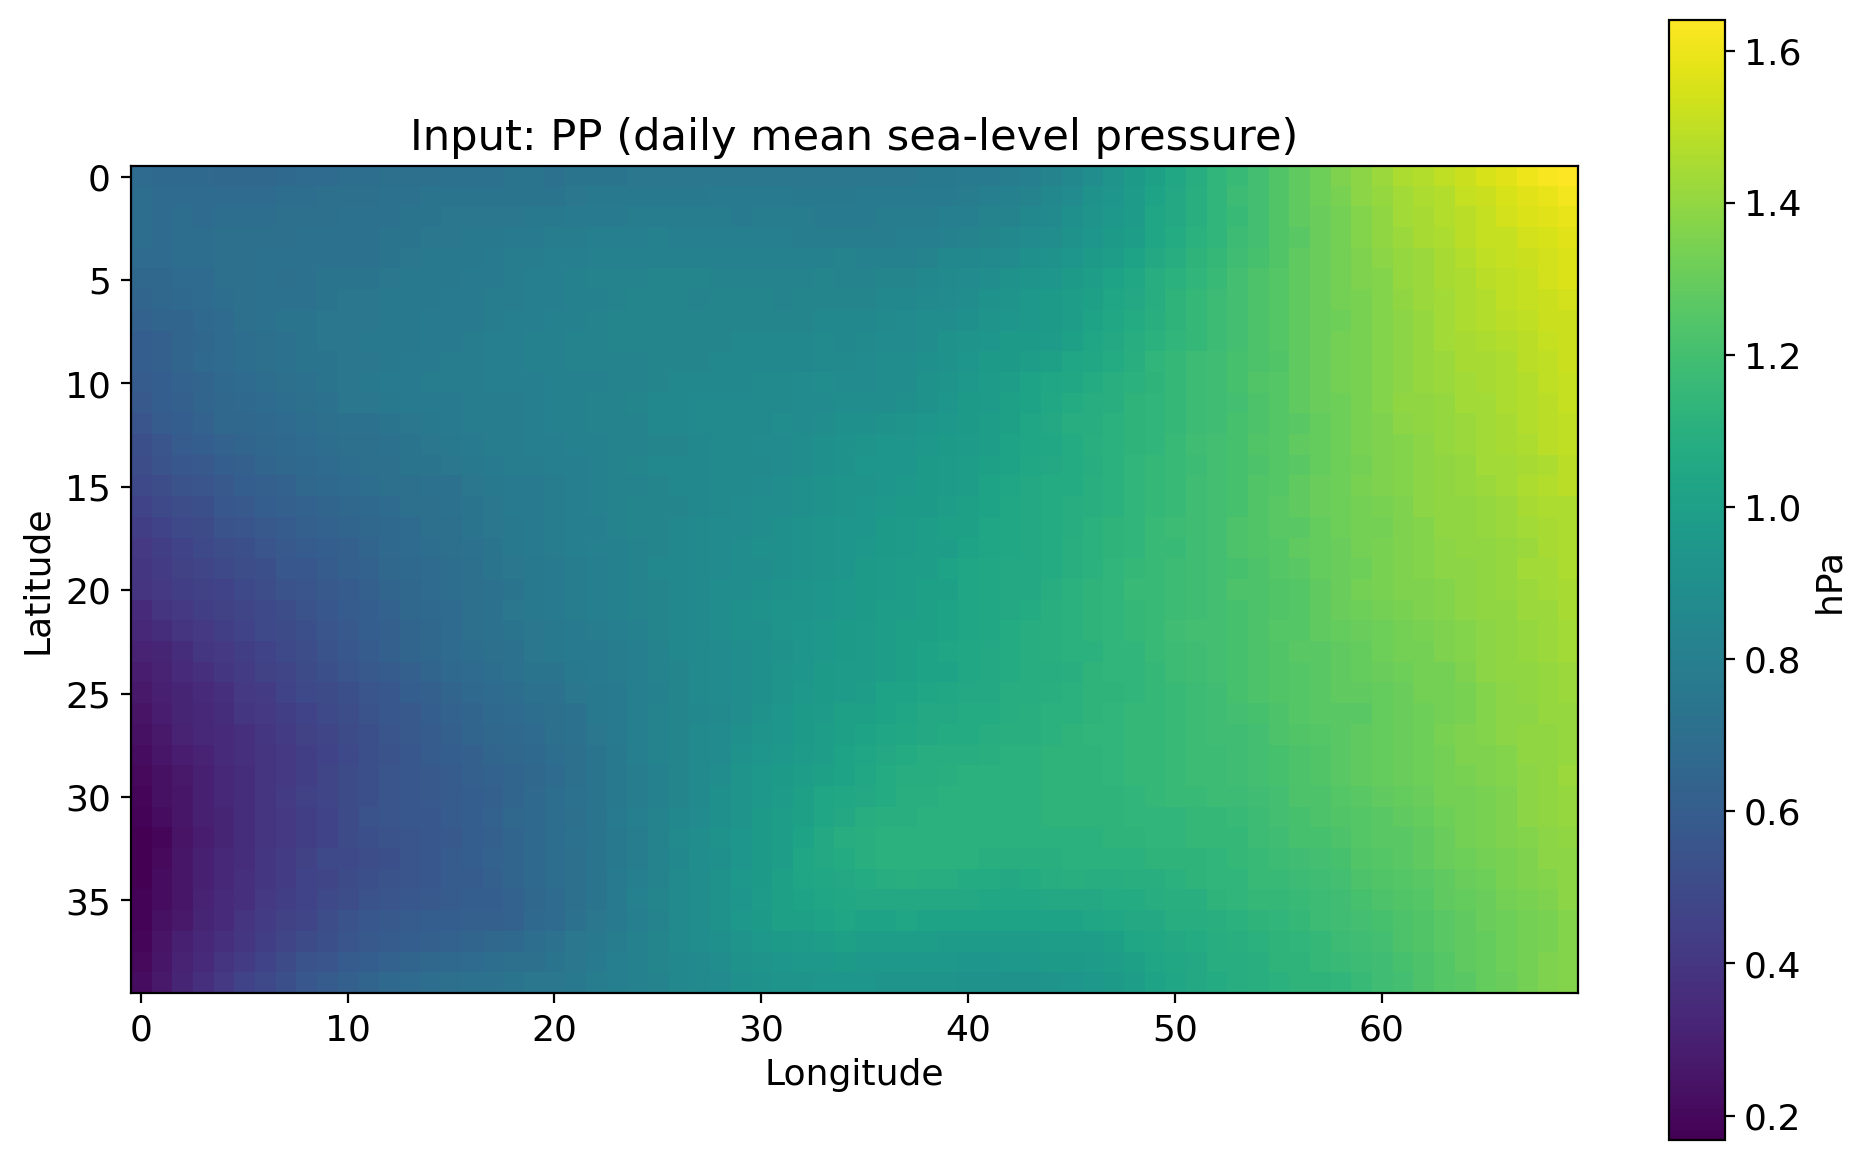

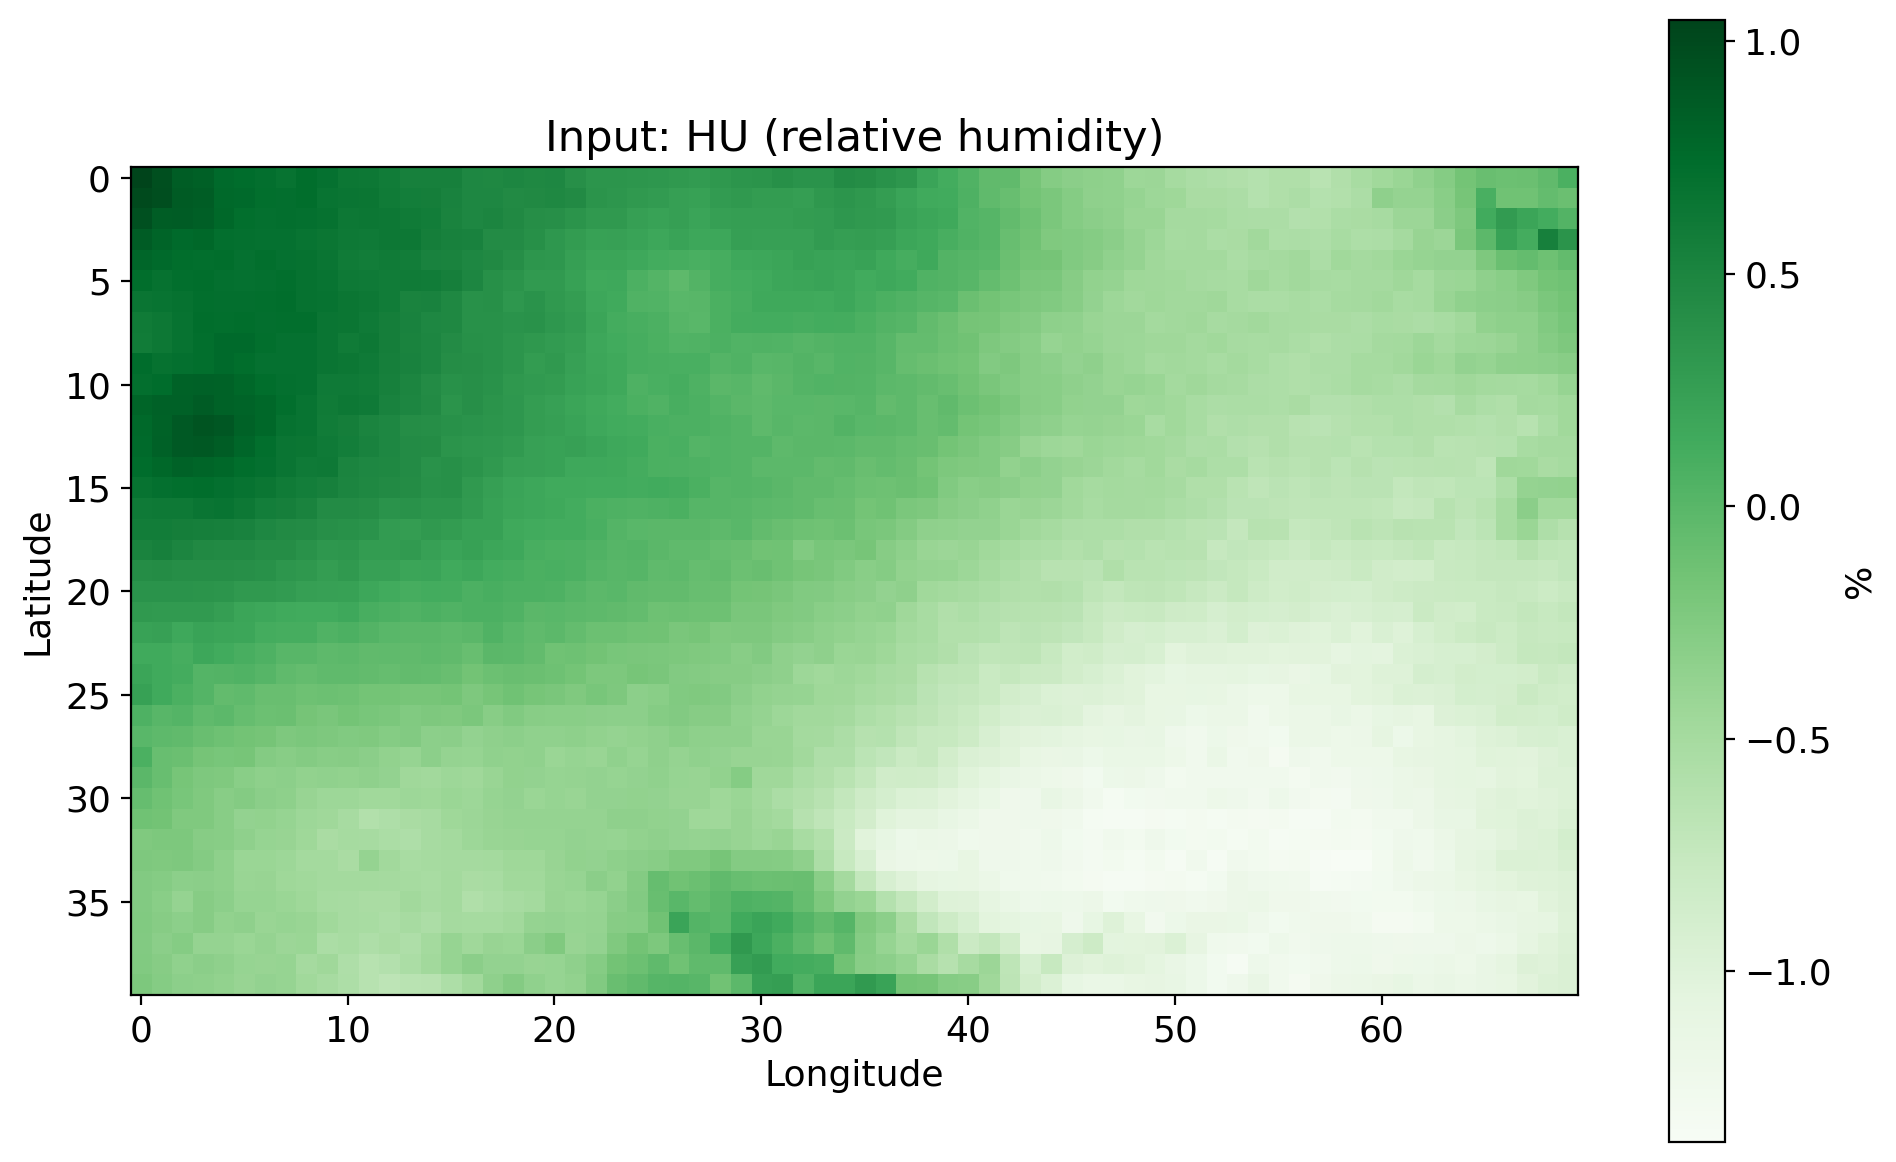

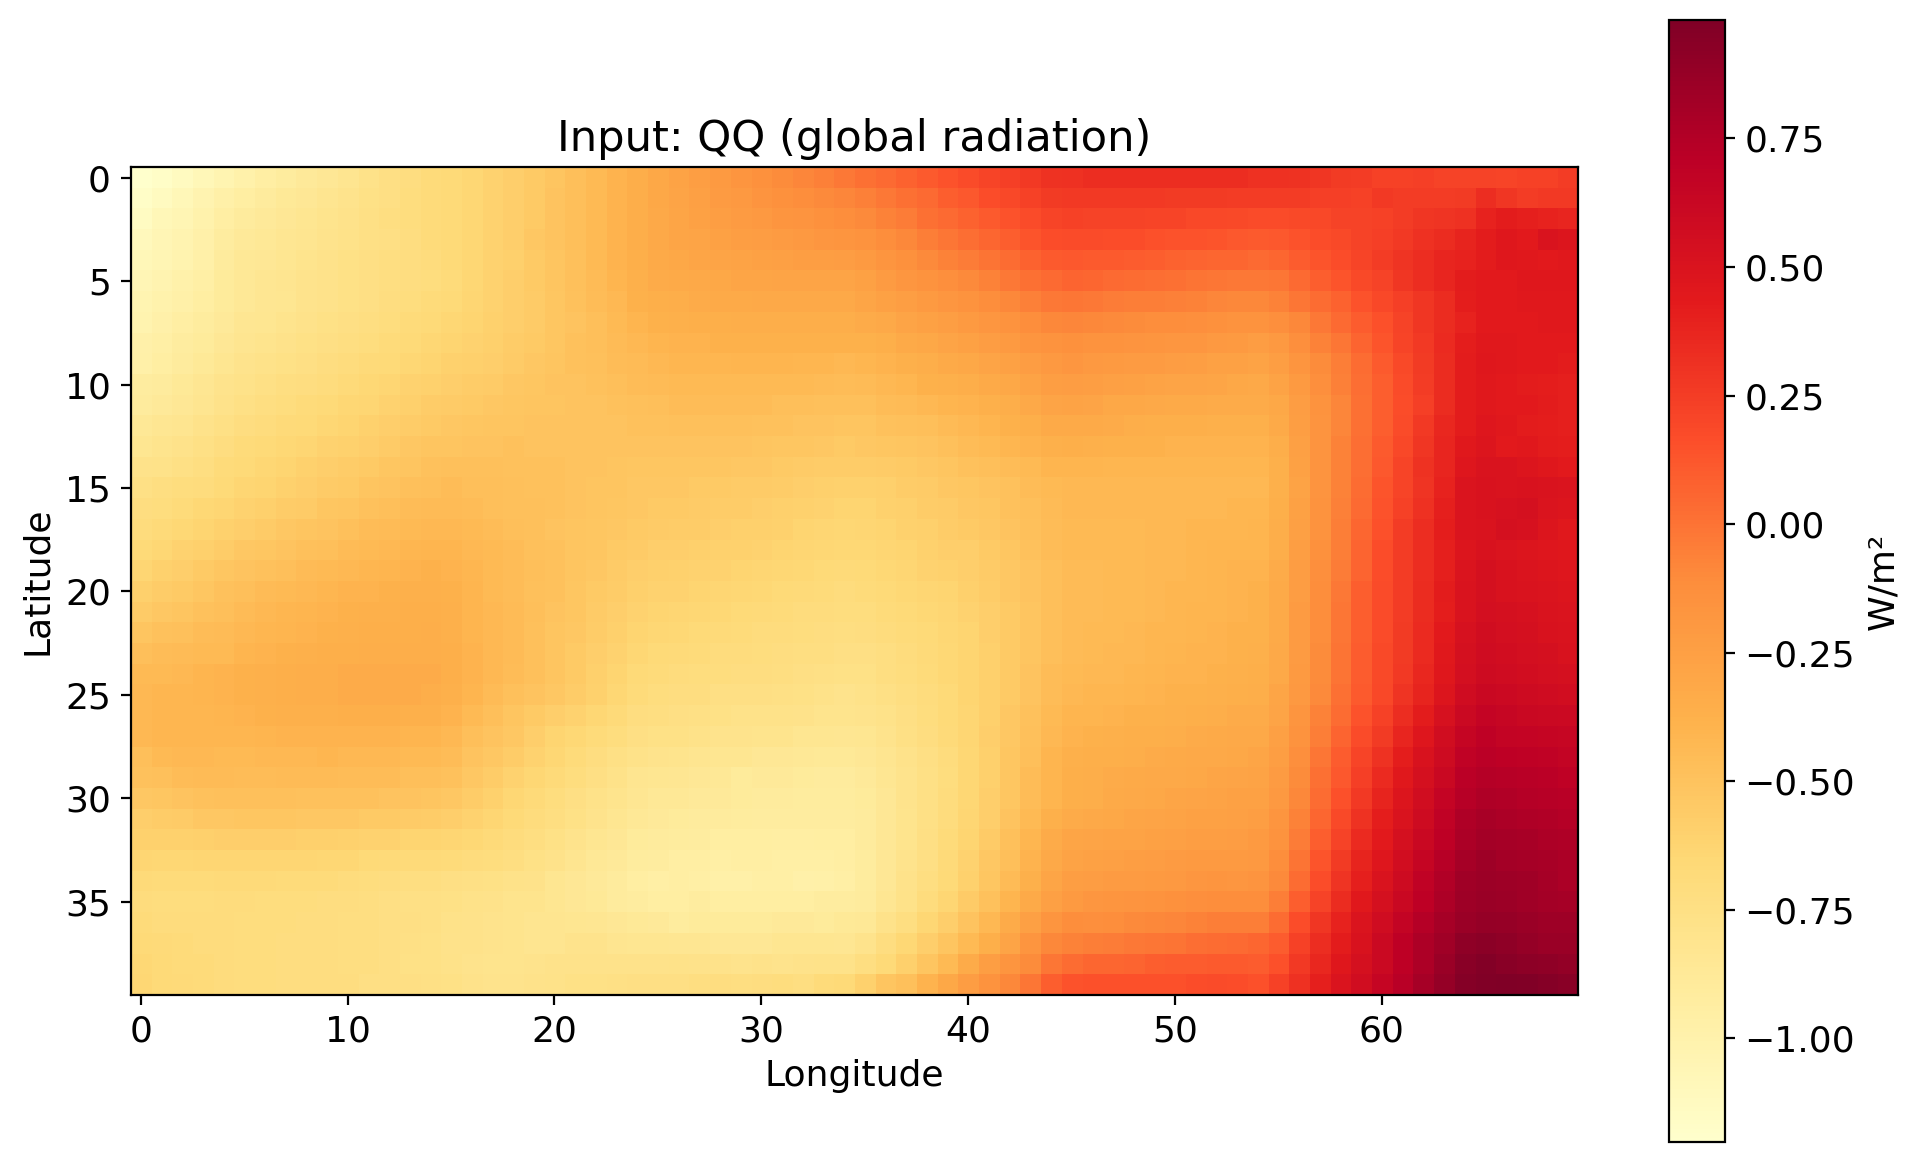

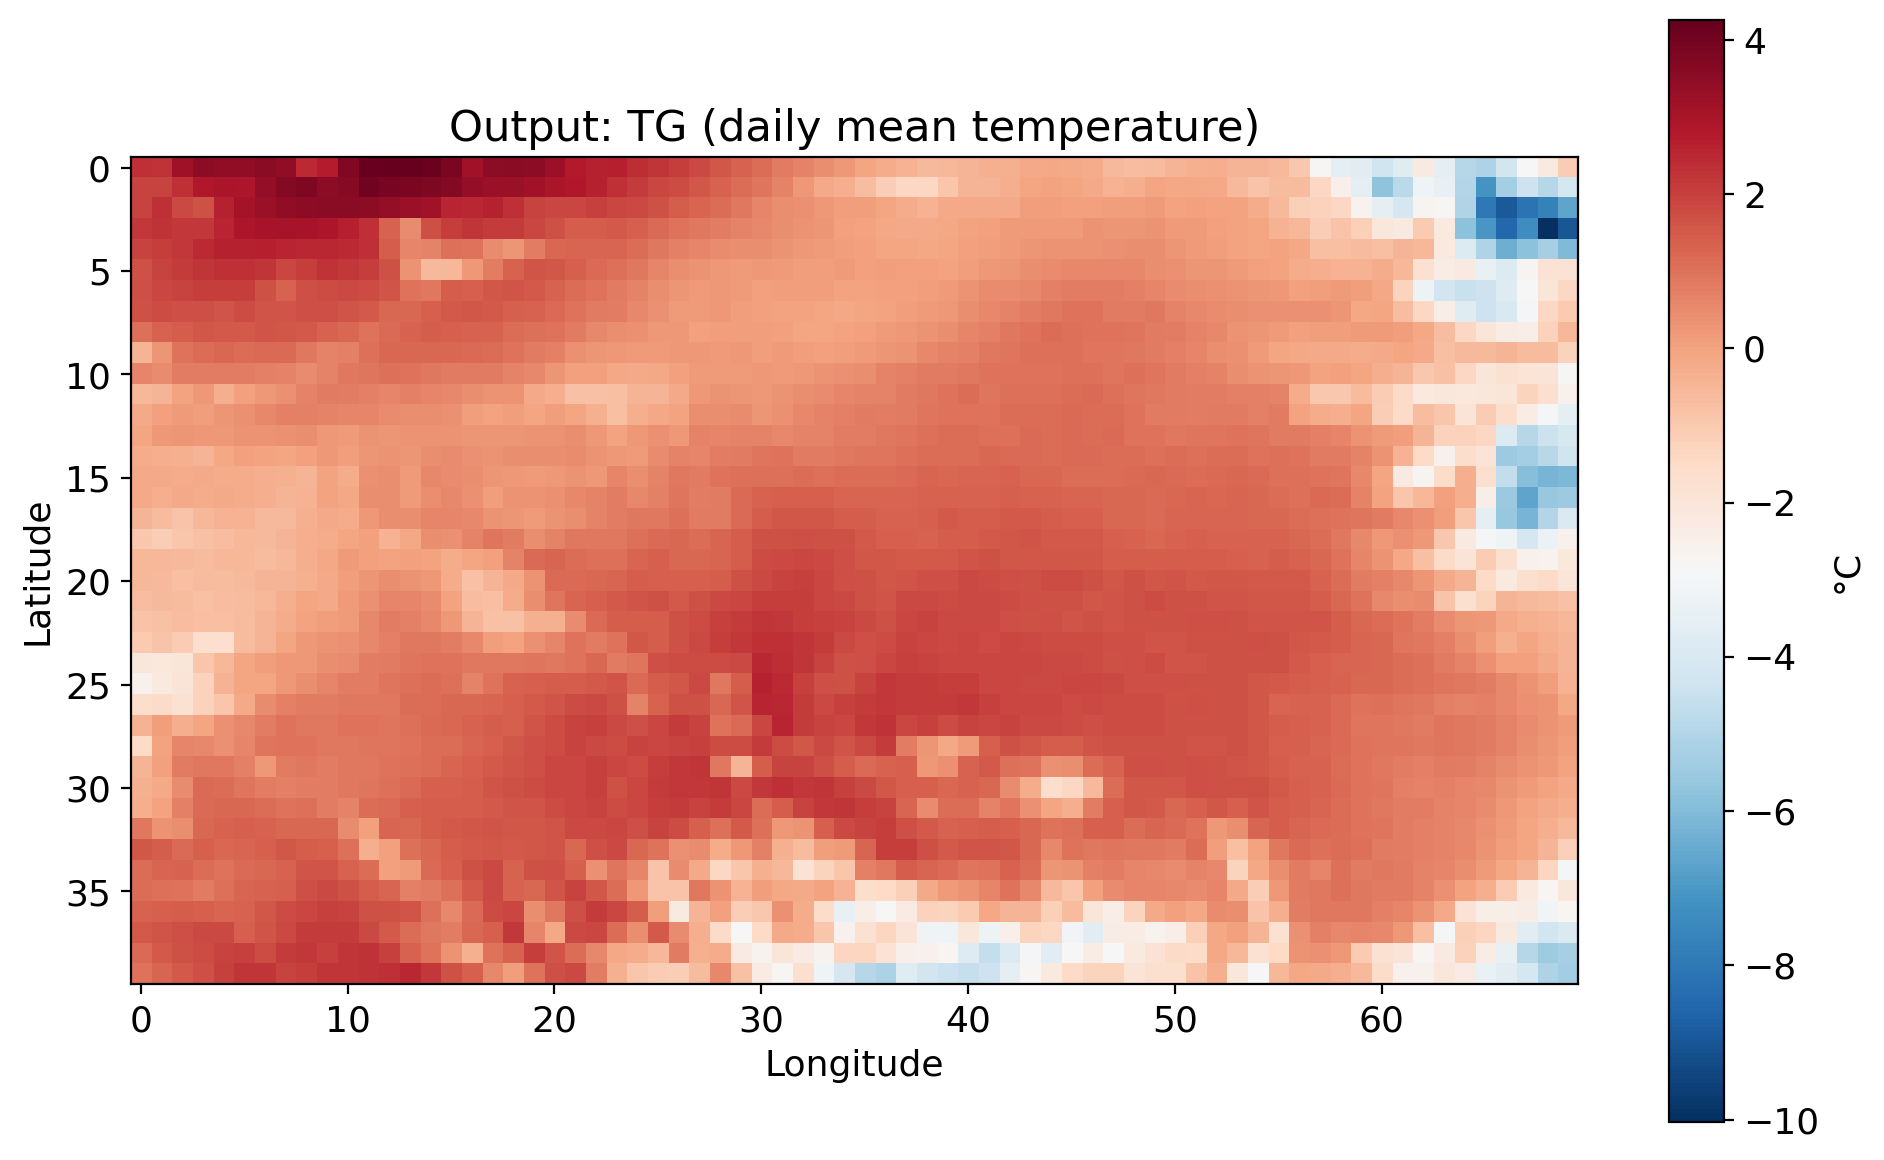

data range: 
**************************************************
RR (daily precipitation sum): [-0.45, 0.41]
**************************************************
PP (daily mean sea-level pressure): [0.17, 1.64]
**************************************************
HU (relative humidity): [-1.37, 1.05]
**************************************************
QQ (global radiation): [-1.20, 0.98]
**************************************************
TG (temperature): [-10.03, 4.26]


In [9]:
visualize_sample_data_separate()

In [10]:
n_neuron       = 128
activation     = 'ReLU' 
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 32
N_layers       = 4 

In [11]:
train_loader = data_dict['train_loader']
val_loader   = data_dict['val_loader']
test_loader  = data_dict['test_loader']

In [12]:
input_dim  = data_dict['input_shape'][0] * data_dict['input_shape'][1] * data_dict['input_shape'][2]  
output_dim = data_dict['output_shape'][0] * data_dict['output_shape'][1]   

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, N_layers=2, activation='ReLU'):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(getattr(nn, activation)())

        for _ in range(N_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(getattr(nn, activation)())

        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):

        x = x.view(x.size(0), -1)   
        return self.net(x)         

In [14]:
model = MLP(input_dim, n_neuron, output_dim, N_layers=N_layers, activation='ReLU')
model.to(device)

MLP(
  (net): Sequential(
    (0): Linear(in_features=11200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=2800, bias=True)
  )
)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)                
        batch_y = batch_y.to(device)               
        batch_y = batch_y.view(batch_y.size(0), -1) 

        optimizer.zero_grad()
        outputs = model(batch_X)                   
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            batch_y = batch_y.view(batch_y.size(0), -1)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/100, Train Loss: 25.0781, Val Loss: 19.5956
Epoch 2/100, Train Loss: 17.2005, Val Loss: 16.7602
Epoch 3/100, Train Loss: 16.0681, Val Loss: 15.4811
Epoch 4/100, Train Loss: 14.7262, Val Loss: 15.0290
Epoch 5/100, Train Loss: 14.0831, Val Loss: 15.9832
Epoch 6/100, Train Loss: 13.3435, Val Loss: 14.3404
Epoch 7/100, Train Loss: 13.0166, Val Loss: 14.4141
Epoch 8/100, Train Loss: 12.4925, Val Loss: 13.7595
Epoch 9/100, Train Loss: 11.9398, Val Loss: 17.2124
Epoch 10/100, Train Loss: 11.5552, Val Loss: 12.4489
Epoch 11/100, Train Loss: 11.2903, Val Loss: 12.8706
Epoch 12/100, Train Loss: 11.1176, Val Loss: 11.9751
Epoch 13/100, Train Loss: 10.5754, Val Loss: 12.5641
Epoch 14/100, Train Loss: 10.3985, Val Loss: 11.7754
Epoch 15/100, Train Loss: 10.1451, Val Loss: 12.0961
Epoch 16/100, Train Loss: 10.0578, Val Loss: 11.8559
Epoch 17/100, Train Loss: 9.8377, Val Loss: 12.2062
Epoch 18/100, Train Loss: 9.5800, Val Loss: 12.9418
Epoch 19/100, Train Loss: 9.5278, Val Loss: 12.1410
Epoch

In [17]:
def plot_history(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

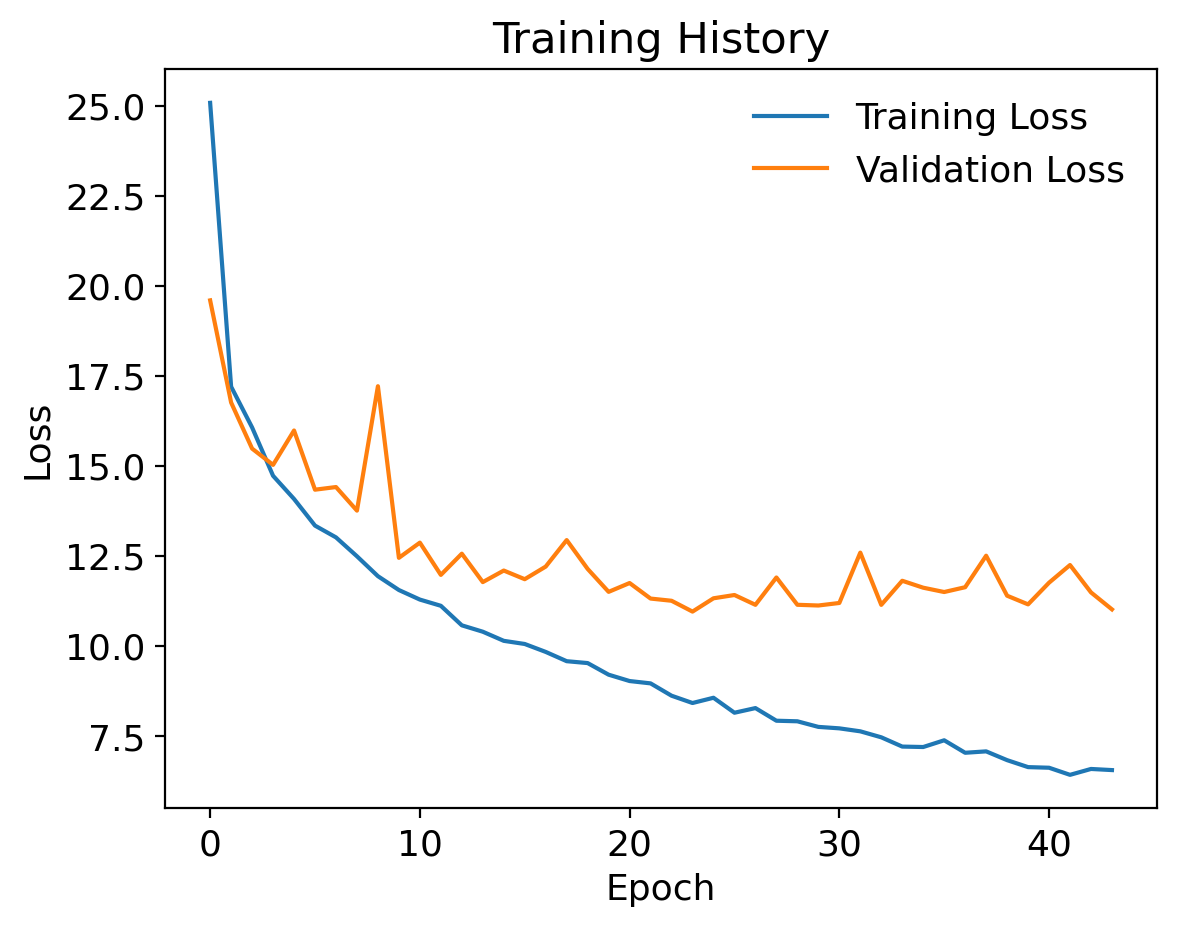

In [18]:
plot_history(train_losses, val_losses)

In [19]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [20]:
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)

In [21]:
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

In [22]:
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=11200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=2800, bias=True)
  )
)


In [23]:
model.eval()
predictions = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:  
        batch_X = batch_X.to(device)
        outputs = model(batch_X)             
        predictions.append(outputs.cpu().numpy())

In [24]:
y_test_pre = np.concatenate(predictions, axis=0) 
y_test_pre = y_test_pre.reshape(len(data_dict['time_test']), 40, 70)

In [25]:
y_test_pre = xr.Dataset(
    coords={
        'time': data_dict['time_test'],
        'latitude': data_dict['spatial_info']['latitude'],
        'longitude': data_dict['spatial_info']['longitude']
    },
    data_vars=dict(
        tg=(['time', 'latitude', 'longitude'], y_test_pre)
    )
)


In [26]:
y_test_tensor = data_dict['test_loader'].dataset.tensors[1] 
y_test = y_test_tensor.numpy()

y_test_xr = xr.Dataset(
    coords={
        'time': data_dict['time_test'],
        'latitude': data_dict['spatial_info']['latitude'],
        'longitude': data_dict['spatial_info']['longitude'],
    },
    data_vars=dict(
        tg=(['time', 'latitude', 'longitude'], y_test)
    )
)


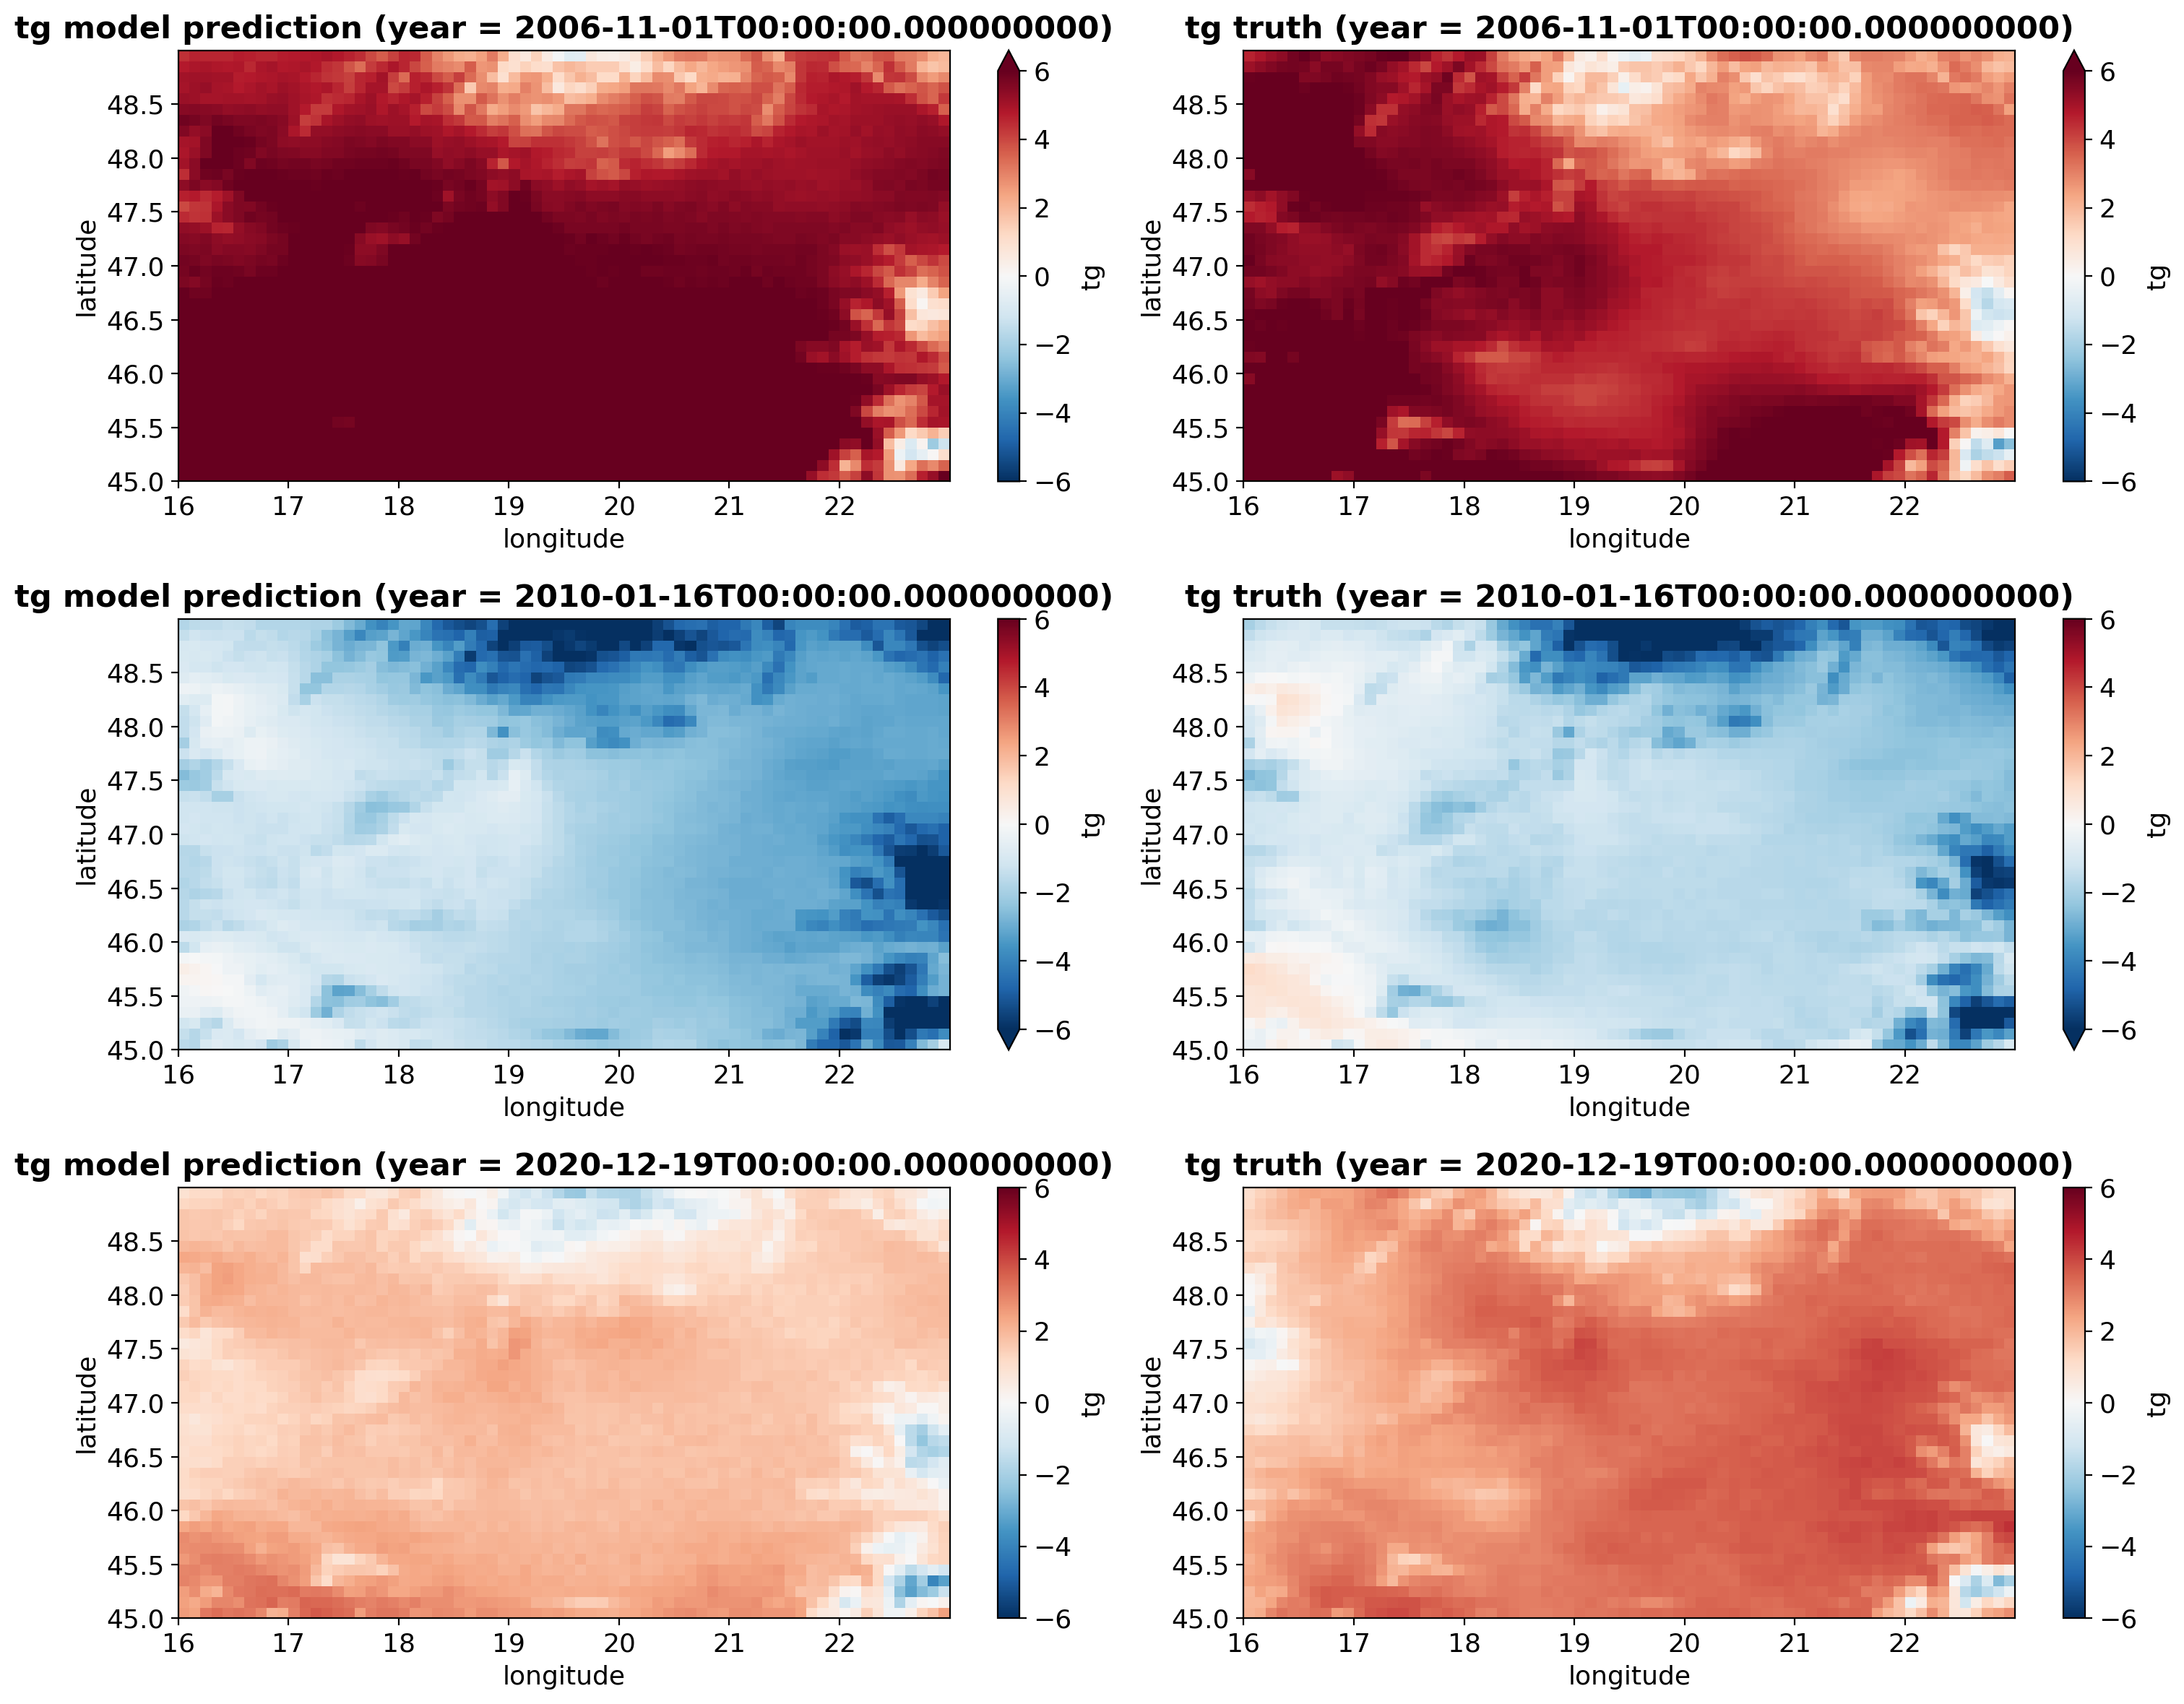

In [27]:
fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=3)

yrs = [
    '2006-11-01T00:00:00.000000000',
    '2010-01-16T00:00:00.000000000',
    '2020-12-19T00:00:00.000000000',
]

vmin, vmax = -6, 6
cmap = 'RdBu_r'

y_test_pre.tg.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tg.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tg.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tg.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tg.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tg.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tg model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tg truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()


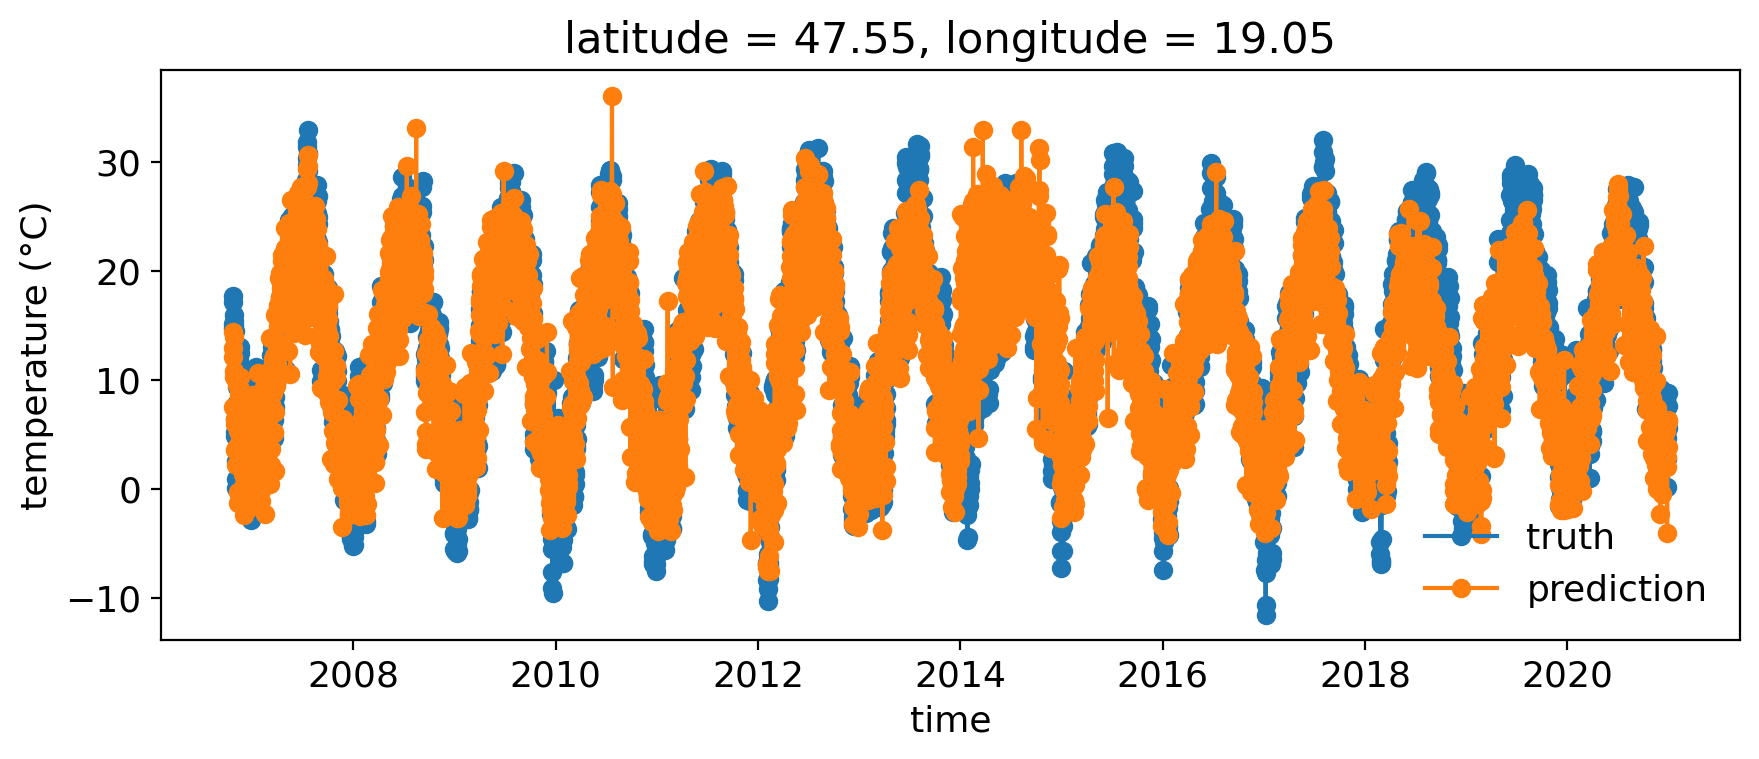

In [28]:
#Budapest
lat = 47.5
lon = 19.0

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

plt.tight_layout()

In [29]:
# combine truth and prediction arrays into a dataframe
city_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.values
city_test_pre = y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.values

df_city_test = pd.DataFrame()
df_city_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.to_dataframe().index
df_city_test["truth"] = city_test_xr
df_city_test["prediction"] = city_test_pre
print(df_city_test.head(10))

# summary statistics of the dataframe
df_city_test.describe()

        time      truth  prediction
0 2006-10-22  14.740000    7.555578
1 2006-10-23  17.109999   12.055329
2 2006-10-24  17.699999   12.919788
3 2006-10-25  15.150000   14.374726
4 2006-10-26  15.059999   13.953589
5 2006-10-27  15.389999   10.828074
6 2006-10-28  15.980000   10.240628
7 2006-10-29  14.460000    3.579517
8 2006-10-30   6.370000    7.333428
9 2006-10-31   4.880000    5.932992


,time,truth,prediction
count,5185,5185.000000,5185.000000
mean,2013-11-26 00:00:00,12.947506,12.213461
min,2006-10-22 00:00:00,-11.500000,-7.515918
25%,2010-05-10 00:00:00,6.040000,4.912214
50%,2013-11-26 00:00:00,13.250000,12.799394
75%,2017-06-14 00:00:00,19.959999,18.876045
max,2020-12-31 00:00:00,32.919998,36.037205
std,NaN,8.617109,7.939254


In [30]:
# combine truth and prediction arrays into a dataframe
city_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.values
city_test_pre = y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.values

df_city_test = pd.DataFrame()
df_city_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.to_dataframe().index
df_city_test["truth"] = city_test_xr
df_city_test["prediction"] = city_test_pre
print(df_city_test.head(10))

# summary statistics of the dataframe
df_city_test.describe()

        time      truth  prediction
0 2006-10-22  14.740000    7.555578
1 2006-10-23  17.109999   12.055329
2 2006-10-24  17.699999   12.919788
3 2006-10-25  15.150000   14.374726
4 2006-10-26  15.059999   13.953589
5 2006-10-27  15.389999   10.828074
6 2006-10-28  15.980000   10.240628
7 2006-10-29  14.460000    3.579517
8 2006-10-30   6.370000    7.333428
9 2006-10-31   4.880000    5.932992


,time,truth,prediction
count,5185,5185.000000,5185.000000
mean,2013-11-26 00:00:00,12.947506,12.213461
min,2006-10-22 00:00:00,-11.500000,-7.515918
25%,2010-05-10 00:00:00,6.040000,4.912214
50%,2013-11-26 00:00:00,13.250000,12.799394
75%,2017-06-14 00:00:00,19.959999,18.876045
max,2020-12-31 00:00:00,32.919998,36.037205
std,NaN,8.617109,7.939254


In [31]:
def area_mean_std_plot(X,label,color,ax,var='tg'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tg_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tg_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tg_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tg_mean+tg_std,tg_mean-tg_std,facecolor=color,alpha=0.2)


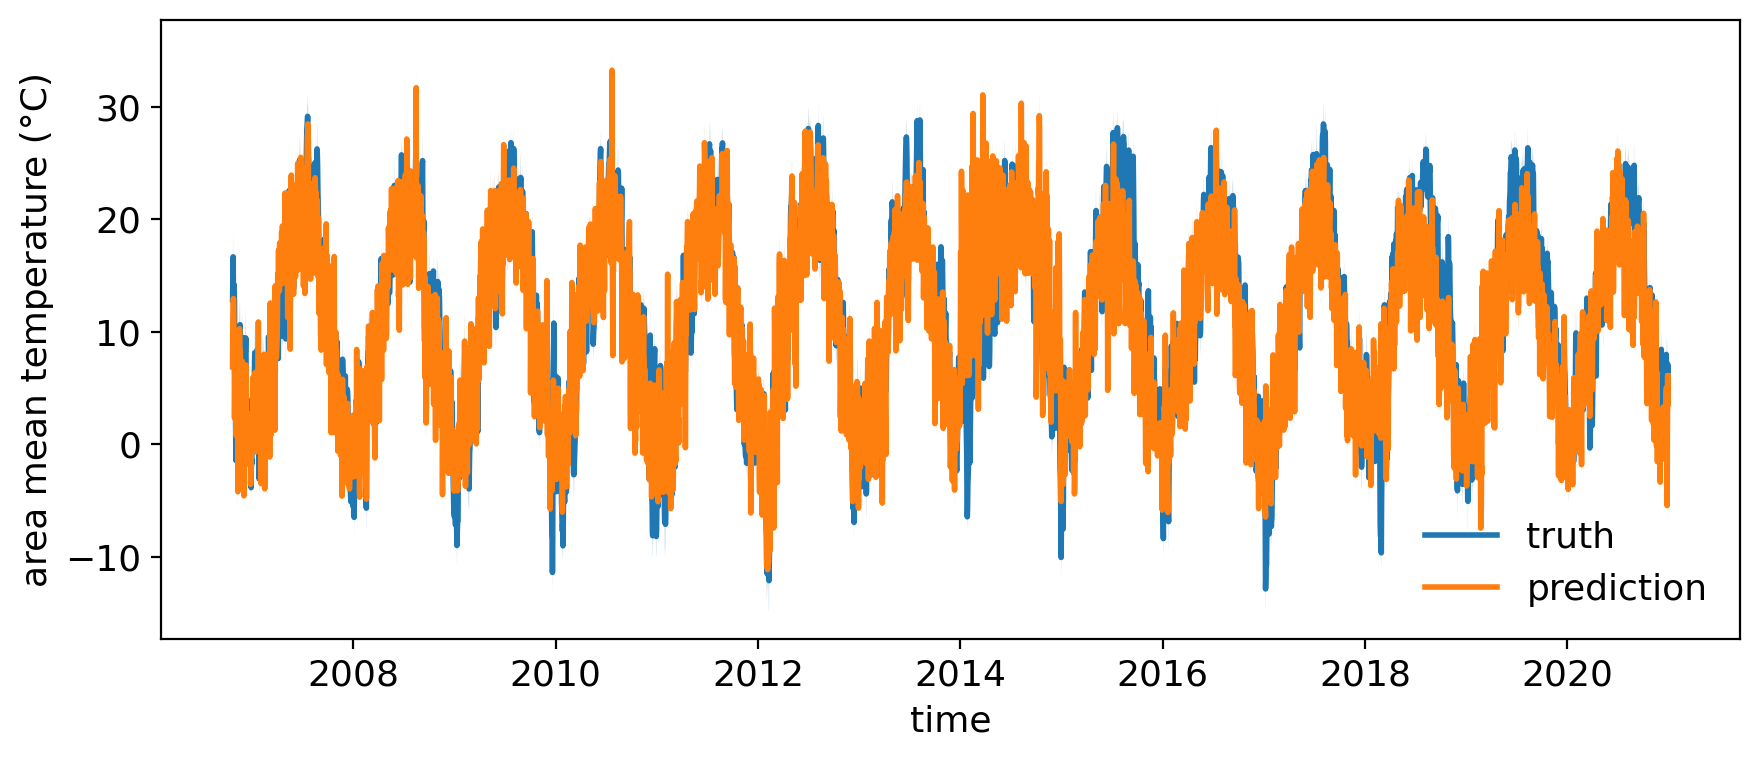

In [32]:
fig,ax = plt.subplots(figsize=(9,4))

area_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
area_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('area mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [33]:
# get area mean temperature
def area_mean(X,var='tg'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tg_mean = X['tg'].weighted(weights).mean(['latitude', 'longitude']).data
    return tg_mean

tg_mean_xr = area_mean(y_test_xr)
tg_mean_pre = area_mean(y_test_pre)

# put into dataframe
df_area_test = pd.DataFrame()
df_area_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.to_dataframe().index
df_area_test["truth"] = tg_mean_xr
df_area_test["prediction"] = tg_mean_pre

print(df_area_test.head(10))

# summary statistics of the dataframe
df_area_test.describe()

        time      truth  prediction
0 2006-10-22  12.845909    6.895097
1 2006-10-23  15.195414   11.089831
2 2006-10-24  16.679997   12.582585
3 2006-10-25  13.584542   12.969964
4 2006-10-26  13.149351   12.635253
5 2006-10-27  14.208594    9.504539
6 2006-10-28  13.384481    8.873962
7 2006-10-29  12.635339    2.322685
8 2006-10-30   4.592192    5.421316
9 2006-10-31   2.636450    4.807691


,time,truth,prediction
count,5185,5185.000000,5185.000000
mean,2013-11-26 00:00:00,11.276771,10.784014
min,2006-10-22 00:00:00,-12.859581,-11.143660
25%,2010-05-10 00:00:00,4.603123,3.818694
50%,2013-11-26 00:00:00,11.468343,11.417542
75%,2017-06-14 00:00:00,18.403224,17.316597
max,2020-12-31 00:00:00,29.176178,33.280113
std,NaN,8.432915,7.749034


In [34]:
rmse_city_test_default = np.sqrt(mean_squared_error(city_test_xr, city_test_pre))

print(f"RMSE for Budapest: {rmse_city_test_default}")

RMSE for Budapest: 4.2820844650268555


In [35]:
rmse_test_default = np.sqrt(mean_squared_error(tg_mean_xr, tg_mean_pre))

print(f"RMSE for area: {rmse_test_default}")

RMSE for area: 4.064909979228367
